In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
import omero
import scipy.cluster.hierarchy as hchy
from seaborn import clustermap

import pandas as pd
from pandas import Series,DataFrame,read_csv, merge,concat,read_hdf,HDFStore
from omero.gateway import BlitzGateway


%matplotlib nbagg
plt.rcParams['image.cmap']='gray'

#hard coded dirs
#dbpath='/home/ubuntu/idr_homes/szleo/features/idr0008-rohn-actinome/screenB/output/'
#dataDir='/home/ubuntu/data'
#scratchDataDir='/scratch/rohnFeatures'


/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:

def connection():
    import omero
    from omero.gateway import BlitzGateway
    c = omero.client("192.168.1.10")
    c.enableKeepAlive(300)
    sf = c.createSession("public", "KejDatfu")
    conn = BlitzGateway(client_obj=c)
    return conn


In [3]:
def buildComposite(st,n,m,smpl=None):
    #nxm shots from st in a grid, as an image
    nr=st.shape[0]
    nc=st.shape[1]
    if smpl==None:
        smpl=st.shape[2]/(n*m)
    res=np.zeros((nr*n,nc*m))
    for i in range(n):
        for j in range(m):
            try:
                res[i*nr:i*nr+nr,j*nc:j*nc+nc]=st[:,:,(i*m+j)*smpl]
            except:
                break
    return res

In [4]:
def getRohnTile(imid,x,y,w,h,chan=0):
#    plateId,x,y,w,h,ti,tf=422,0,0,200,200,50,150
    try:
        conn = connection()

        im = conn.getObject("Image", imid)
        pix=im.getPrimaryPixels()

        z=0;c=chan;
        tile = (x, y, w, h) 
        plane = pix.getTile(theC=c,tile=tile)
    except:
        raise
    finally:
        conn._closeSession()
    
    return plane

In [5]:
def getBulkAnnotationAsDf(screenID,conn):
#    ofId=8118685
    sc=conn.getObject('Screen',screenID)
    for ann in sc.listAnnotations():
        if isinstance(ann, omero.gateway.FileAnnotationWrapper):
            if (ann.getFile().getName()=='bulk_annotations'):
                if (ann.getFile().getSize()> 147625090): #about 140Mb?
                    print "that's a big file..."
                    return None
                ofId=ann.getFile().getId()
                break


    original_file = omero.model.OriginalFileI(ofId, False)

    openTable = conn.c.sf.sharedResources().openTable(original_file)
    rowCount = openTable.getNumberOfRows()

    #table to df

    column_names = [col.name for col in openTable.getHeaders()]

    black_list = []
    column_indices = []
    for column_name in column_names:
        if column_name in black_list:
            continue
        column_indices.append(column_names.index(column_name))

    table_data = openTable.slice(column_indices, None)
    data = []
    for index in range(rowCount):
        row_values = [column.values[index] for column in table_data.columns]
        data.append(row_values)

    dfAnn=DataFrame(data)
    dfAnn.columns=column_names
    return dfAnn


## phenotype clustering

In [6]:
#conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
conn=connection()


In [ ]:
ofId=8118685

original_file = omero.model.OriginalFileI(ofId, False)

openTable = conn.c.sf.sharedResources().openTable(original_file)
rowCount = openTable.getNumberOfRows()

In [ ]:
#table to df

column_names = [col.name for col in openTable.getHeaders()]

black_list = []
column_indices = []
for column_name in column_names:
    if column_name in black_list:
        continue
    column_indices.append(column_names.index(column_name))

table_data = openTable.slice(column_indices, None)
data = []
for index in range(rowCount):
    row_values = [column.values[index] for column in table_data.columns]
    data.append(row_values)
    
dfRhonAnn=DataFrame(data)
dfRhonAnn.columns=column_names


In [9]:
scId=206
dfRhonAnn=getBulkAnnotationAsDf(scId,conn)

In [10]:

#transforming phenotypes into one hot booleans
BoolCols=[]
PhenLab=[]
for iphen in range(1,41):
#for col in dfRhonAnn.columns:
#    if ('Phenotype' in col)&~('Term' in col):
    col='Phenotype '+str(iphen)
    dfRhonAnn['Bool'+col]=~(dfRhonAnn[col] =='')
    BoolCols.append('Bool'+col)
    PhenLab.append(dfRhonAnn[col].unique()[1])

In [11]:
#phenMap=dfRhonAnn[dfRhonAnn['Has Phenotype']=='yes'].groupby('Gene Symbol')[BoolCols].sum()>0
phenMap=dfRhonAnn[dfRhonAnn['Has Phenotype']=='yes'].groupby('Gene Symbol')[BoolCols].sum()>0
phenMap=phenMap[phenMap.sum(axis=1)>0]
phenMap.columns=PhenLab
Z = hchy.linkage(phenMap, 'ward')
Zt = hchy.linkage(phenMap.transpose(), 'ward')


<IPython.core.display.Javascript object>


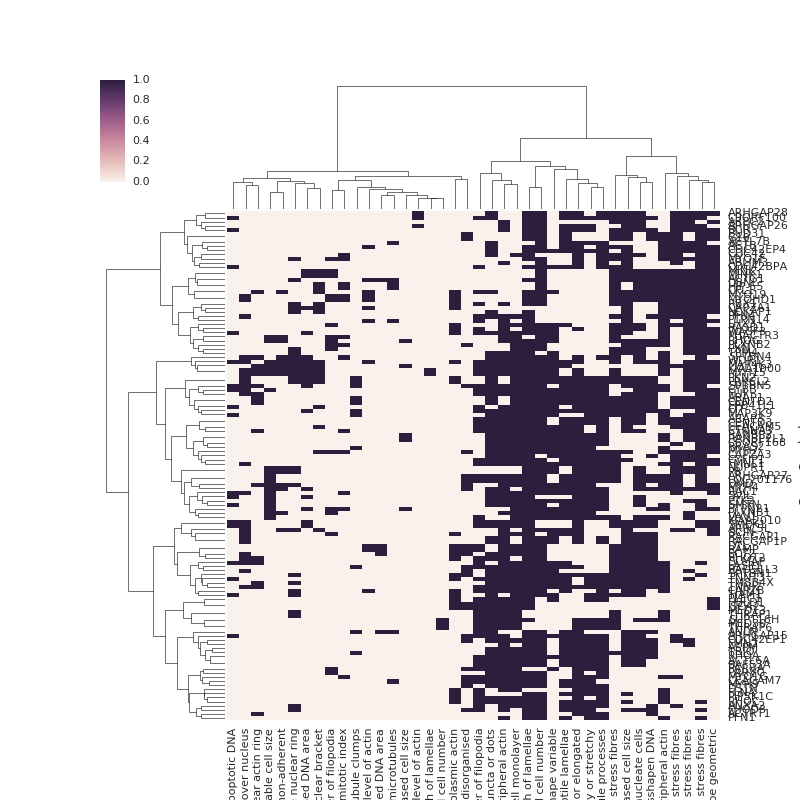

In [12]:
cg=clustermap(phenMap,row_linkage=Z,col_linkage=Zt)
for item in cg.ax_heatmap.get_xticklabels():
    item.set_rotation(90)
for item in cg.ax_heatmap.get_yticklabels():
    item.set_rotation(0)


In [13]:
#a gallery of tiles for a bunch of phenotypes

#hard coded, but correspond to tile size used for CHARM features computation
X=[  0, 580, 116, 348, 232, 464]
Y=[  0, 348,  87, 174, 261]
ni=10
w=116
h=86

#some phenotype
phs=range(20,30)

tiles=np.zeros((h,w,len(phs)*ni))
for ph,kk in zip(phs,phs):
    #print ph
    ws=dfRhonAnn[dfRhonAnn['BoolPhenotype '+str(ph)]].Well
    for ii in range(ni):
        we=random.choice(ws.values)
        we=conn.getObject('Well',we)
        i=we.getImage()   
        x=random.choice(X)
        y=random.choice(Y)
        #print x,y,w,h,i.getId()
        tiles[:,:,ii+kk*ni] =getRohnTile(i.getId(),x,y,w,h,chan=1)

plt.figure(figsize=(12,12))
imc=buildComposite(tiles,len(phs),ni)
plt.grid(False)
plt.imshow(imc)
    

ResourceError: exception ::omero::ResourceError
{
    serverStackTrace = ome.conditions.ResourceError: Error instantiating pixel buffer: /data/OMERO/ManagedRepository/demo_2/2015-09/22/13-44-54.603/Act1_Plate10-SP-A8.HTD
	at ome.io.nio.PixelsService.createBfPixelBuffer(PixelsService.java:867)
	at ome.io.nio.PixelsService._getPixelBuffer(PixelsService.java:597)
	at ome.io.nio.PixelsService.getPixelBuffer(PixelsService.java:509)
	at ome.io.nio.PixelsService.getPixelBuffer(PixelsService.java:503)
	at ome.services.RawPixelsBean.setPixelsId(RawPixelsBean.java:280)
	at sun.reflect.GeneratedMethodAccessor1352.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at org.springframework.aop.support.AopUtils.invokeJoinpointUsingReflection(AopUtils.java:307)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.invokeJoinpoint(ReflectiveMethodInvocation.java:183)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:150)
	at ome.security.basic.EventHandler.invoke(EventHandler.java:154)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:172)
	at ome.tools.hibernate.SessionHandler.doStateful(SessionHandler.java:216)
	at ome.tools.hibernate.SessionHandler.invoke(SessionHandler.java:200)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:172)
	at org.springframework.transaction.interceptor.TransactionInterceptor.invoke(TransactionInterceptor.java:108)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:172)
	at ome.tools.hibernate.ProxyCleanupFilter$Interceptor.invoke(ProxyCleanupFilter.java:249)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:172)
	at ome.services.util.ServiceHandler.invoke(ServiceHandler.java:121)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:172)
	at org.springframework.aop.framework.JdkDynamicAopProxy.invoke(JdkDynamicAopProxy.java:202)
	at com.sun.proxy.$Proxy103.setPixelsId(Unknown Source)
	at sun.reflect.GeneratedMethodAccessor1352.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at org.springframework.aop.support.AopUtils.invokeJoinpointUsingReflection(AopUtils.java:307)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.invokeJoinpoint(ReflectiveMethodInvocation.java:183)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:150)
	at ome.security.basic.BasicSecurityWiring.invoke(BasicSecurityWiring.java:93)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:172)
	at ome.services.blitz.fire.AopContextInitializer.invoke(AopContextInitializer.java:43)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:172)
	at org.springframework.aop.framework.JdkDynamicAopProxy.invoke(JdkDynamicAopProxy.java:202)
	at com.sun.proxy.$Proxy103.setPixelsId(Unknown Source)
	at sun.reflect.GeneratedMethodAccessor1363.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at ome.services.blitz.util.IceMethodInvoker.invoke(IceMethodInvoker.java:172)
	at ome.services.throttling.Callback.run(Callback.java:56)
	at ome.services.throttling.InThreadThrottlingStrategy.callInvokerOnRawArgs(InThreadThrottlingStrategy.java:56)
	at ome.services.blitz.impl.AbstractAmdServant.callInvokerOnRawArgs(AbstractAmdServant.java:140)
	at ome.services.blitz.impl.RawPixelsStoreI.setPixelsId_async(RawPixelsStoreI.java:194)
	at sun.reflect.GeneratedMethodAccessor1362.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at org.springframework.aop.support.AopUtils.invokeJoinpointUsingReflection(AopUtils.java:307)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.invokeJoinpoint(ReflectiveMethodInvocation.java:183)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:150)
	at omero.cmd.CallContext.invoke(CallContext.java:78)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:172)
	at org.springframework.aop.framework.JdkDynamicAopProxy.invoke(JdkDynamicAopProxy.java:202)
	at com.sun.proxy.$Proxy104.setPixelsId_async(Unknown Source)
	at omero.api._RawPixelsStoreTie.setPixelsId_async(_RawPixelsStoreTie.java:258)
	at omero.api._RawPixelsStoreDisp.___setPixelsId(_RawPixelsStoreDisp.java:634)
	at omero.api._RawPixelsStoreDisp.__dispatch(_RawPixelsStoreDisp.java:1530)
	at IceInternal.Incoming.invoke(Incoming.java:222)
	at Ice.ConnectionI.invokeAll(ConnectionI.java:2482)
	at Ice.ConnectionI.dispatch(ConnectionI.java:1258)
	at Ice.ConnectionI.message(ConnectionI.java:1213)
	at IceInternal.ThreadPool.run(ThreadPool.java:321)
	at IceInternal.ThreadPool.access$300(ThreadPool.java:12)
	at IceInternal.ThreadPool$EventHandlerThread.run(ThreadPool.java:693)
	at java.lang.Thread.run(Thread.java:745)

    serverExceptionClass = ome.conditions.ResourceError
    message = Error instantiating pixel buffer: /data/OMERO/ManagedRepository/demo_2/2015-09/22/13-44-54.603/Act1_Plate10-SP-A8.HTD
}